In [2]:
# %reset -f

import sys
import os
import joblib
import matplotlib
import numpy as np
import pandas as pd 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error

# install custom package with: pip install git+https://github.com/owenodriscoll/AutoML.git
sys.path.insert(0, os.path.abspath('..'))  # hacky way to import within package
from AutoML import AutomatedRegression
from importlib import reload
import AutoML; reload(AutoML); from AutoML.misc import outlier_detector, plot_envelope_single
# from AutoML.misc import outlier_detector, plot_envelope_single

In [3]:
#%% load data

data_dir = '/Users/opodriscoll/Documents/Data/'
df_rolls = pd.read_csv(f'{data_dir}df_rolls.csv')
df_cells = pd.read_csv(f'{data_dir}df_cells.csv')

df = pd.concat([df_cells, df_rolls]) 

In [101]:
#%% filtering of estimates 

# -- conditions for filtering
window_effect_threshhold_low = 0.5
window_effect_threshhold_high = 1.5
S_windfield_xi_norm_std_threshhold = 0.25
inertial_subrange_length_fraction_threshold = 0.2 
inertial_subrange_length_threshold = 200 # m
peak_max_threshold = 2950
peak_min_threshold = 610
min_heatflux = 0 # (into atmos)
max_obukhov = 0

# -- filtering
df_val = df.loc[(df['L_era5'] < max_obukhov) & (df['hsb_era5'] > min_heatflux) & (df['hlb_era5'] > min_heatflux)]
df_val = df_val[(df_val.window_effect >= window_effect_threshhold_low) & (df_val.window_effect <= window_effect_threshhold_high)]
df_val = df_val[df_val.S_windfield_xi_norm_std <= S_windfield_xi_norm_std_threshhold]
df_val = df_val[(df_val.spectral_peak - df_val.spectral_valley)/df_val.spectral_peak >= inertial_subrange_length_fraction_threshold]
df_val = df_val[((df_val.spectral_peak - df_val.spectral_valley) >= inertial_subrange_length_threshold)]
df_val = df_val[(df_val.spectral_peak< peak_max_threshold) & (df_val.spectral_peak > peak_min_threshold)]

# -- outlier removal between parameters 'window_effect' and 'S_windfield_xi_norm_std'
df_val = outlier_detector(df_val, 'window_effect', 'S_sigma0_xi_norm_std', pca_comp=0.80, neighbours = 100, plot_PCA=False)    # S_normalised_deviation, sign_wind2
df_val = df_val.reset_index(drop = True)  

# -- select observation data only
keep_after_index = list(df_val.keys()).index('U_n') # U_n is first observation column
keep_before_index = list(df_val.keys()).index('energy_dir_range') +1 # S_windfield_xi_norm_std is the last measured param 
df_obs = df_val.iloc[:,keep_after_index:keep_before_index] 

# -- replace original estimate of Obukhov length by the a logarithmic version 
df_obs['L'] = np.log10(abs(df_obs['L']))

<Axes: >

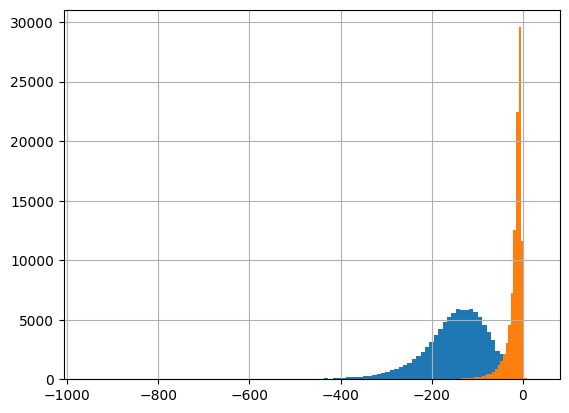

In [112]:
list(df_val.keys())
df_val.slhf_era5.hist(bins = 100)
df_val.sshf_era5.hist(bins = 100)


<Axes: >

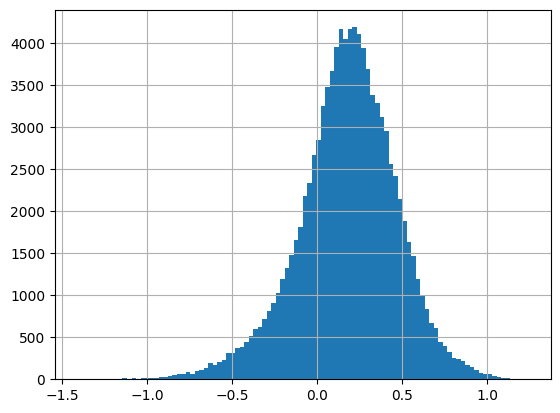

In [102]:
np.log10(-(df_val.tair_era5-df_val.tsea_era5)).hist(bins = 100)

<Axes: >

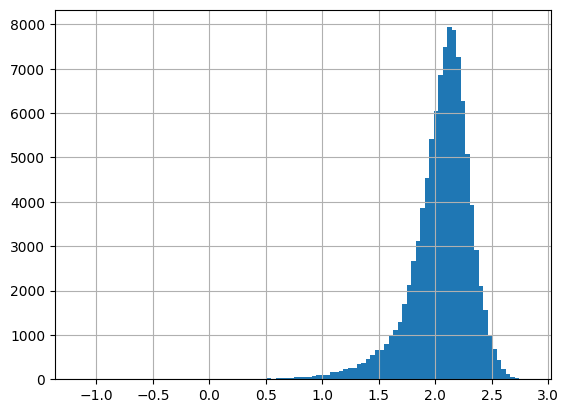

In [103]:
list(df_val.keys())
np.log10((df_val.hlb_era5)).hist(bins = 100)

In [118]:
#%% Select data, split into X and y- matrix and exclude scenes for analysis later on

# -- observation
X_sar = df_obs.drop(columns = ['S_sigma0_xi_norm_std', 'S_sigma0_xi_mean', 'wdir'])
# X_scat = df_obs[['U_n', 'incidence_avg', 'energy_dir_range']] 

# -- validation
y = np.log10(abs(df_val.hlb_era5))# np.log10(df_val['hsb_era5'])  #np.log10(df_val.hsb_era5)

In [123]:
#%% Prepare Machine Learning 

result_sar = AutomatedRegression(
    y = y, 
    X = X_sar, 
    test_frac = 0.2, 
    timeout = 1200,  # currently times out after 300 seconds, for study set to 2400
    n_trial = 20,   # currently allowed a max of 20 trials, for study set to 200
    metric_optimise = mean_squared_error,
    metric_assess = [mean_squared_error, r2_score, explained_variance_score, median_absolute_error],
    reload_study = True,
    reload_trial_cap=True,
    optimisation_direction = 'minimize', 
    write_folder = "/Users/opodriscoll/Documents/Scripts/AutoML/examples/testdir/hlb_v5",
    models_to_optimize = ['lightgbm','bayesianridge', 'lassolars'], #'catboost', 'xgboost'
    random_state = 42)


In [124]:
#%% Apply the regression
result_sar.apply()

[I 2023-09-29 12:30:32,025] Using an existing study with name 'regression_lightgbm' instead of creating a new one.


[I 2023-09-29 12:30:32,059] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2023-09-29 12:30:32,087] Using an existing study with name 'regression_lassolars' instead of creating a new one.
[I 2023-09-29 12:30:32,112] Using an existing study with name 'regression_lightgbm' instead of creating a new one.
[I 2023-09-29 12:30:32,149] Using an existing study with name 'regression_bayesianridge' instead of creating a new one.
[I 2023-09-29 12:30:32,181] Using an existing study with name 'regression_lassolars' instead of creating a new one.


_________________________
Stacked model overwritten
_________________________



In [125]:
result_sar.summary

{'lightgbm_best': [[0.017546961703093455, 0.0007393289927829755],
  [0.7610502938260489, 0.0058188889494555675],
  [0.7610652005545606, 0.005812676644097725],
  [0.069066165066248, 0.001427230282306119]],
 'bayesianridge_best': [[0.03534919070069718, 0.0011898934423072828],
  [0.5184587708751855, 0.012288330907416684],
  [0.5185649701813725, 0.012303649658421326],
  [0.0968209365508556, 0.0010848708097444884]],
 'lassolars_best': [[0.035338653916339426, 0.0011782410897434622],
  [0.5186026921277384, 0.012062821760586895],
  [0.5187089602391319, 0.012078266697378052],
  [0.09674834760527891, 0.00108929819914201]],
 'stacked': [[0.017312772811546567, 0.0007319691426778883],
  [0.7642257455409858, 0.006345127236493049],
  [0.7642407298562477, 0.006339485207850965],
  [0.06834451871758582, 0.0016426643429265657]]}

In [126]:
# 10**result_sar.y_pred.values-10**result_sar.y_test.values
r2_score(result_sar.y_test, result_sar.y_pred)

0.7642045349668642

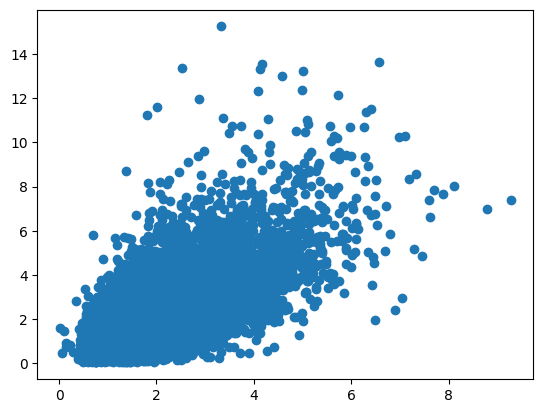

In [75]:
import matplotlib.pyplot as plt 
plt.scatter(10**result_sar.y_pred, 10**result_sar.y_test)


/Users/opodriscoll/miniconda3/envs/env_AutoML/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/opodriscoll/miniconda3/envs/env_AutoML/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/opodriscoll/miniconda3/envs/env_AutoML/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/opodriscoll/miniconda3/envs/env_AutoML/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


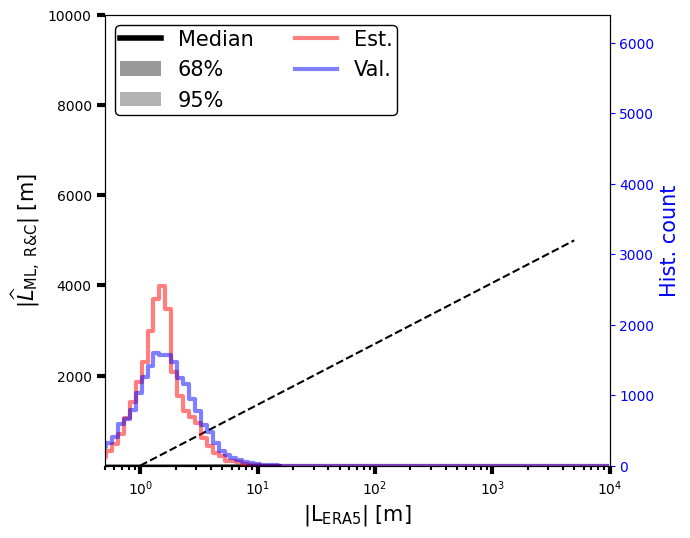

In [12]:
#%% Plot results of SAR

df_plot = pd.DataFrame()
df_plot['y_test'] = 10**result_sar.y_test
df_plot['y_ML'] = 10**result_sar.y_pred

hist_steps = 100
title = 'Correction using stacked regression from ERA5 $L$'
x_axis_title = r"|L$_{\mathrm{ERA5}}$| [$\mathrm{m}$]"
y_axis_title = r"|$\widehat{L}_{\mathrm{ML,\ R&C}}$| [$\mathrm{m}$]"
param_test = 'y_test'
param_predict = 'y_ML'

bin_centre, bin_median, bin_count_test, bin_count_pred, bin_std, fig2 = plot_envelope_single(df_plot = df_plot, hist_steps = hist_steps, param_test = param_test, param_predict = param_predict, 
                                                 title = title, x_axis_title = x_axis_title, y_axis_title = y_axis_title, alpha = 0.5, legend = True, axis_scale = 'linear')

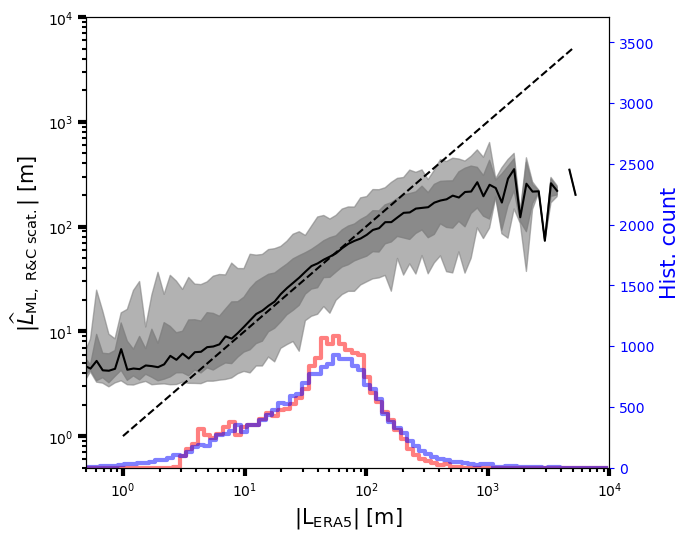

In [12]:
#%% and of the synthetic scat.

df_plot = pd.DataFrame()
df_plot['y_test'] = 10**result_scat.y_test
df_plot['y_ML'] = 10**result_scat.y_pred

hist_steps = 100
title = 'Correction using stacked regression from ERA5 $L$'
x_axis_title = r"|L$_{\mathrm{ERA5}}$| [$\mathrm{m}$]"
y_axis_title = r"|$\widehat{L}_{\mathrm{ML,\ R&C\ scat.}}$| [$\mathrm{m}$]"
param_test = 'y_test'
param_predict = 'y_ML'

bin_centre, bin_median, bin_count_test, bin_count_pred, bin_std, fig2 = eqm.plot_envelope_single(df_plot = df_plot, hist_steps = hist_steps, param_test = param_test, param_predict = param_predict, 
                                                 title = title, x_axis_title = x_axis_title, y_axis_title = y_axis_title, alpha = 0.5, legend = False)

In [42]:
#%% load previous study

# -- scat.
stacking_regressor_scat = joblib.load(f"{data_dir}/examp_rolls_cells_regression_scat/" + "stacked_model.joblib")
pred_scat = stacking_regressor_scat.predict(result_scat.X_test)

r2 = r2_score(result_scat.y_test, pred_scat)
mae = median_absolute_error(result_scat.y_test, pred_scat)
print(f"Scat. to ERA5: Model explains {np.round(r2*100,1)}% of variance with a Median Absolute Error of {np.round(mae,3)} (on a log scale)")

# -- SAR
stacking_regressor_sar = joblib.load(f"{data_dir}/examp_rolls_cells_regression_sar/" + "stacked_model.joblib")
pred_sar = stacking_regressor_sar.predict(result_sar.X_test)

r2 = r2_score(result_sar.y_test, pred_sar)
mae = median_absolute_error(result_sar.y_test, pred_sar)
print(f"SAR to ERA5: Model explains {np.round(r2*100,1)}% of variance with a Median Absolute Error of {np.round(mae,3)} (on a log scale)")

Scat. to ERA5: Model explains 70.9% of variance with a Median Absolute Error of 0.161 (on a log scale)
SAR to ERA5: Model explains 78.5% of variance with a Median Absolute Error of 0.13 (on a log scale)


In [35]:
# -- calculate performance for four example scenes 

df_subset_prep = df_subset.iloc[:,keep_after_index:keep_before_index].drop(columns = ['S_sigma0_xi_norm_std', 'S_sigma0_xi_mean', 'wdir']) 
df_subset_prep['L'] = np.log10(abs(df_subset_prep['L']))

df_subset['L_sar'] = 10**stacking_regressor_sar.predict(df_subset_prep)
df_subset['L_scat'] = 10**stacking_regressor_scat.predict(df_subset_prep[['U_n', 'incidence_avg', 'energy_dir_range']])
df_subset[['L_era5', 'L_sar', 'L_scat', 'UrfN_era5', 'U_n']]

,L_era5,L_sar,L_scat,UrfN_era5,U_n
38335,-14.715210,14.007095,28.359969,6.171668,5.820312
53332,-11.679557,10.130231,26.672853,6.331063,5.820312
65788,-64.121573,61.761200,42.719528,6.100500,5.898438
71508,-64.686217,63.563270,38.671784,5.920818,5.507812


In [43]:
#%% ensure that test indexes and test data across the SAR and scat. study are identical

if (result_scat.test_index == result_sar.test_index).all():
    test_index = result_scat.test_index
    
if (result_scat.y_test == result_sar.y_test).values.all():
    y_test = result_scat.y_test

/export/home/owen/anaconda3/envs/env_paper/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


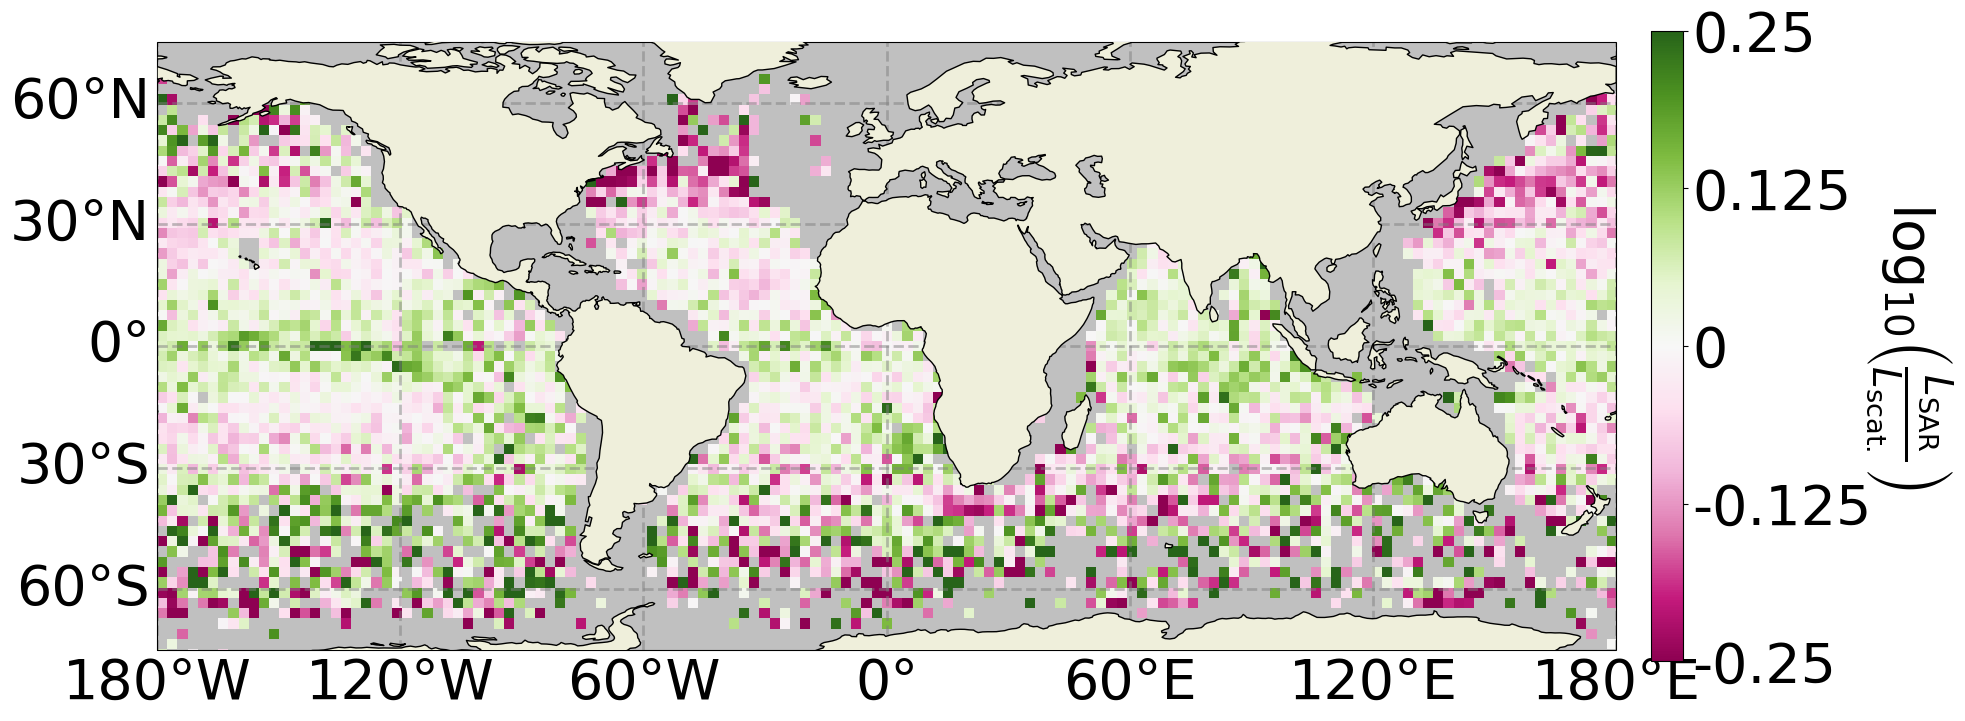

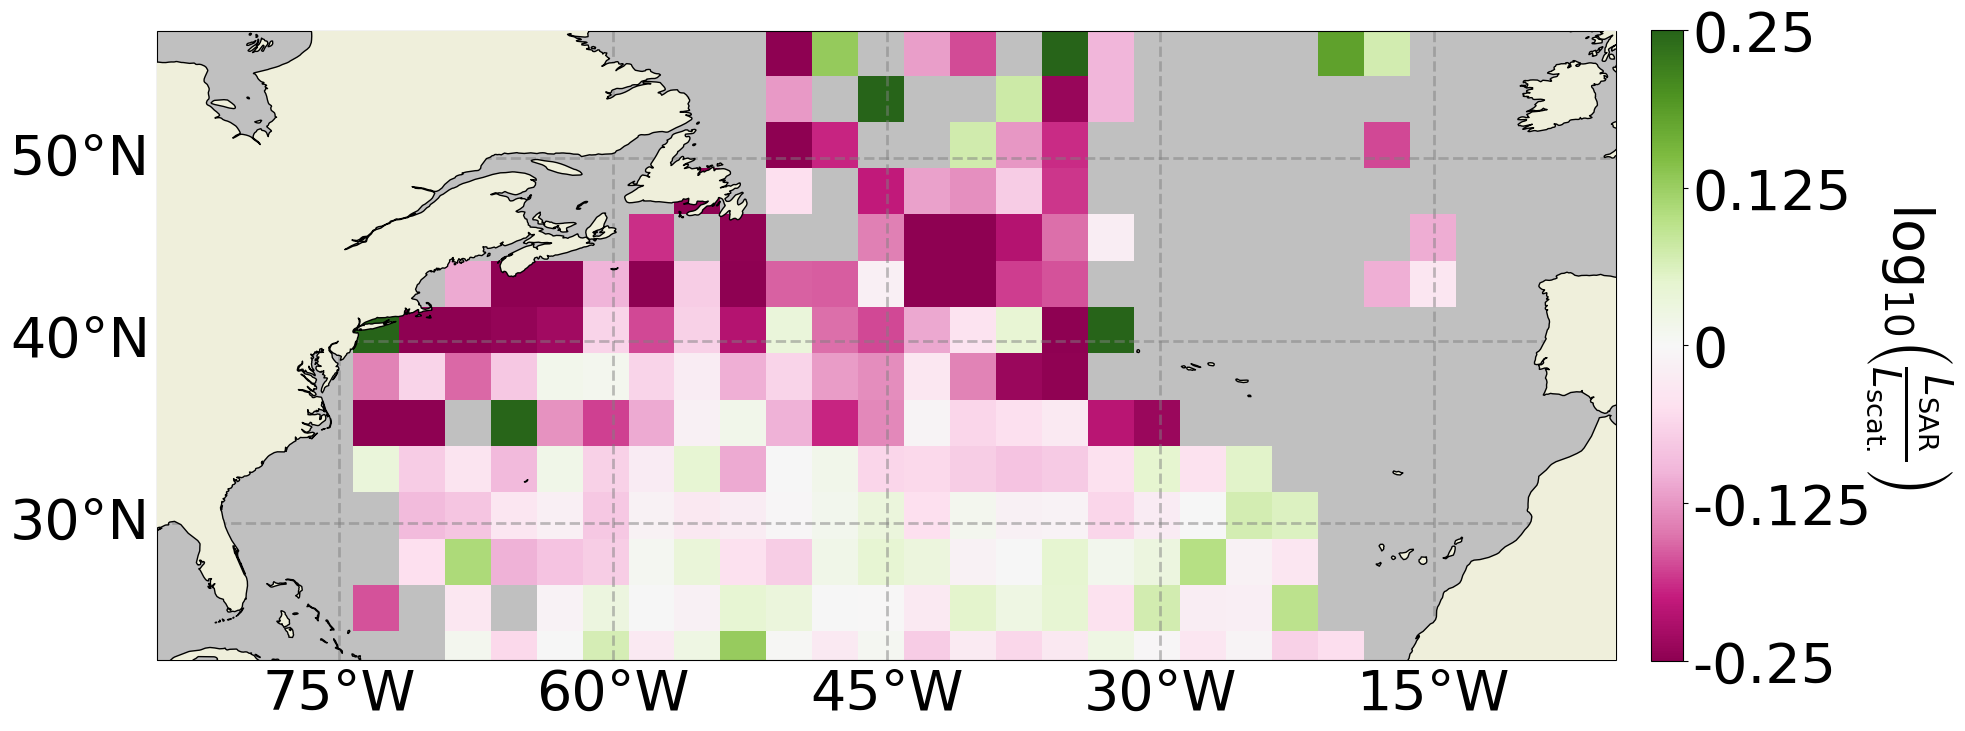

In [46]:
#%% plot global difference between SAR and scat results

df_input = pd.DataFrame()
df_input['pred_scat'] = pred_scat
df_input['pred_sar'] = pred_sar
df_input['lat'] = df_val['lat_sar'][test_index].reset_index(drop = True);
df_input['lon'] = df_val['lon_sar'][test_index].reset_index(drop = True);
df_input['scat_sar_diff'] = df_input['pred_sar'] - df_input['pred_scat']
variables = ['scat_sar_diff']
statistics = ['median']
norms = [matplotlib.colors.Normalize(vmin=-0.25, vmax=0.25)]
cmaps = ['PiYG'] # PiYG
rows = 1
columns = 1
shrink = 0.65 # 0.65
resolution = 2.5
pad = 0.02
labelpad = 60 # 30
title = ''
fontsize = 40 # 20
labelsize = 40 # 20
extent = [-85, -5, 22.5, 57]
xticks = [-90, -75, -60, -45, -30, -15, 0]#[-105, -90, -75, -60, -45, -30, -15, 0] #[-90, -75, -60, -45, -30, -15, 0]
yticks = [20, 30, 40, 50]
figsize = (20, 10)
cbar_ticks = [-0.5, -0.25, -0.125, 0, 0.125, 0.25, 0.5]
cbar_labels = ['-0.50', '-0.25', '-0.125', '0', '0.125', '0.25', '0.50']
cbar_title = r'$\mathrm{log_{10}}\left(\frac{L_{\mathrm{SAR}}}{L_{\mathrm{scat.}}} \right)$' #r'$\Delta \theta$ [$^{\circ}$]' # $\widehat{L}$ [m] $L_{\mathrm{ERA5}}$
fig, datas = eqm.world_maps_single(df_input = df_input, variables = variables, title = title, cbar_title = cbar_title, statistics = statistics, 
                              norms = norms, cmaps = cmaps, rows = rows, columns = columns, shrink = shrink, resolution = resolution, pad = pad, 
                              fontsize = fontsize, labelsize = labelsize, labelpad = labelpad, cbar_ticks=cbar_ticks, cbar_labels=cbar_labels,
                              figsize = figsize,
                                # extent = extent, xticks = xticks, yticks = yticks
                              )

fig2, datas2 = eqm.world_maps_single(df_input = df_input, variables = variables, title = title, cbar_title = cbar_title, statistics = statistics, 
                              norms = norms, cmaps = cmaps, rows = rows, columns = columns, shrink = shrink, resolution = resolution, pad = pad, 
                              fontsize = fontsize, labelsize = labelsize, labelpad = labelpad, cbar_ticks=cbar_ticks, cbar_labels=cbar_labels,
                              figsize = figsize,
                              extent = extent, xticks = xticks, yticks = yticks
                              )